In [1]:
import pandas as pd
import pickle

import os

from torchmetrics.regression import SymmetricMeanAbsolutePercentageError
from sklearn.linear_model import LinearRegression
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
def metric(y_pred, y_test):
    y_test = torch.FloatTensor(y_test)
    y_pred = torch.FloatTensor(y_pred)

    ad_smape = SymmetricMeanAbsolutePercentageError()
    smape_adjust = torch.mean(torch.stack([ad_smape(y_pred.detach().cpu()[i], y_test.detach().cpu()[i]) * 0.5 for i in range(len(y_test))]))
    return smape_adjust

In [3]:
prepo_data_folder = "/home/smart01/SFLAB/sanguk/mind_br_data_prepro/"
# Load sales data
sales_df = pd.read_csv(os.path.join(prepo_data_folder, f"item_sale_per_week_12.csv"), index_col="품번")
sales_df = sales_df.drop(index=['MTPT6102', 'MUPT6102'])

# text description load
text_des = pd.read_excel(os.path.join("/home/smart01/SFLAB/sanguk/mind_br_data/", "품번description(텍스트).xlsx"), index_col="품번")

# Load Google trends
cat_trend_per_item = pickle.load(
    open(os.path.join(prepo_data_folder, "cat_trend_per_item_v3.pkl"), 'rb'))
fab_trend_per_item = pickle.load(
    open(os.path.join(prepo_data_folder, "fab_trend_per_item_v3.pkl"), 'rb'))
col_trend_per_item = pickle.load(
    open(os.path.join(prepo_data_folder, "col_trend_per_item_v4.pkl"), 'rb'))

data_path = '/home/smart01/SFLAB/su_GTM_t/GTM_T_sanguk/'
df = pd.read_csv('../../data/preprocess/all_meta_data.csv', index_col='item_number')
# df = df.loc[:,~df.columns.str.startswith('img')]

In [4]:
# df = pd.DataFrame()

# df['fabric'] = meta_df.loc[:,meta_df.columns[meta_df.columns.str.startswith('fabric')]].idxmax(axis=1).apply(lambda x:x.split('_')[-1])
# df['color'] = meta_df.loc[:,meta_df.columns[meta_df.columns.str.startswith(('main_color','color'))]].idxmax(axis=1).apply(lambda x:x.split('_')[-1])
# df['category'] = meta_df.loc[:,meta_df.columns[meta_df.columns.str.startswith('category')]].idxmax(axis=1).apply(lambda x:x.split('_')[-1])
# df['sales_mean'] = meta_df.loc[:,'sales_mean']
# df = pd.concat([df, meta_df.loc[:,meta_df.columns[meta_df.columns.str.startswith(('img','text'))]]],axis=1)

test_list = pickle.load(open("/home/smart01/SFLAB/su_GTM_t/GTM_T_sanguk/12salesweek_test_item_number296.pkl", 'rb')).drop("MTPT6102")[:]
train_list = sales_df.index[~sales_df.index.isin(test_list)].drop('JROP328D').drop('JROP328E').drop('MQPT3129')[:]

train_df = df.loc[train_list].reset_index()
test_df = df.loc[test_list].reset_index()

len(train_df), len(test_df)

(1438, 295)

In [5]:
colcat = train_df.groupby(['color', 'category'], as_index=False)['sales_mean'].agg(['count','mean'])
colcat = colcat.rename({'mean':'group_mean'}, axis=1)
ex_colcat = colcat.loc[colcat['count'] < 30, ['color','category','group_mean']].reset_index(drop=True)
colcat = colcat.loc[colcat['count'] >= 30, ['color','category','group_mean']].reset_index(drop=True)


merge_df = pd.merge(test_df.iloc[:,1:], colcat, on=['color', 'category'])
metric(merge_df['group_mean'].values, merge_df['sales_mean'].values)

tensor(0.3108)

In [6]:
ex_merge_df = pd.merge(test_df.iloc[:,1:], ex_colcat, on=['color', 'category'])
metric(ex_merge_df['group_mean'].values, ex_merge_df['sales_mean'].values), len(ex_merge_df)

(tensor(0.3692), 39)

In [7]:
mg_train = pd.merge(train_df, colcat).set_index('품번')
mg_test = pd.merge(test_df, colcat).set_index('품번')

mg_train['diff'] = mg_train['sales_mean'] - mg_train['group_mean']
mg_test['diff'] = mg_test['sales_mean'] - mg_test['group_mean']

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(mg_train['sales_mean'].values.reshape(-1,1))

In [9]:
scaler.transform(mg_train['sales_mean'].values.reshape(-1,1))

array([[-0.46170696],
       [-0.45433037],
       [-0.47369391],
       ...,
       [-0.38655795],
       [-0.37733721],
       [-0.35013604]])

In [10]:
X_train = mg_train.iloc[:,4:-2].values
y_train = scaler.transform(mg_train['sales_mean'].values.reshape(-1,1)).squeeze()

X_test = mg_test.iloc[:,4:-2].values
y_test = mg_test['sales_mean'].values

reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1,1)).squeeze()

metric(y_pred, y_test)

tensor(0.7263)

In [11]:
import pickle

('BEIGE', 'OP') 34 11


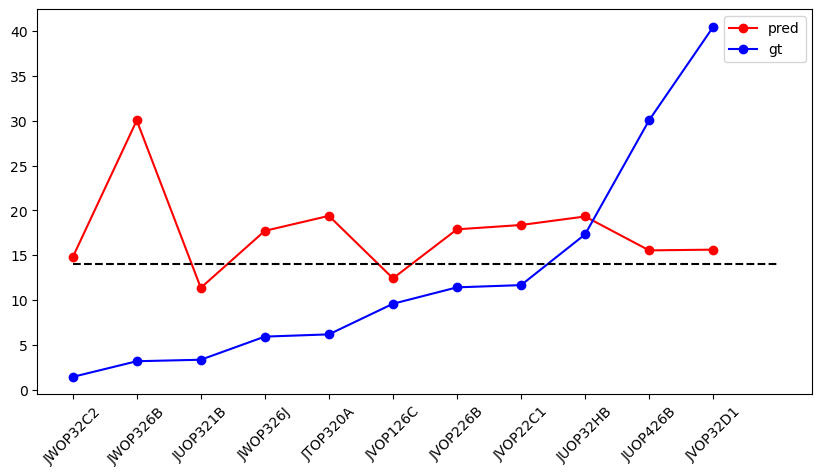

('BLACK', 'OP') 111 33


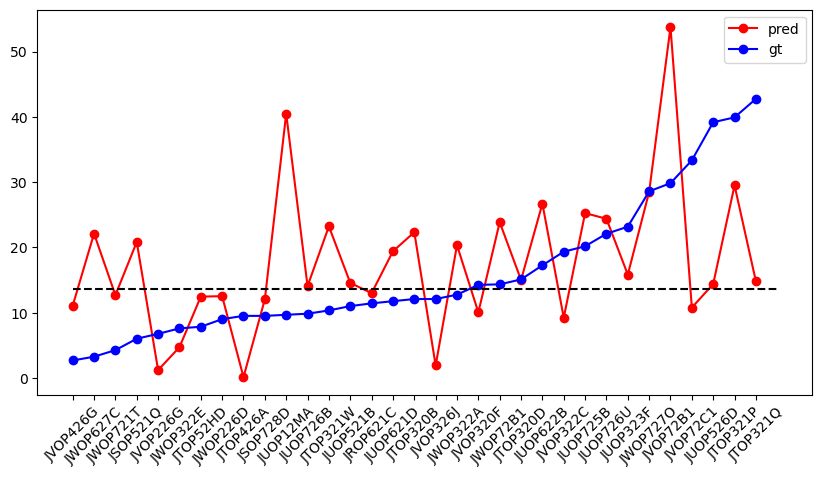

('BLUE', 'DP') 75 8


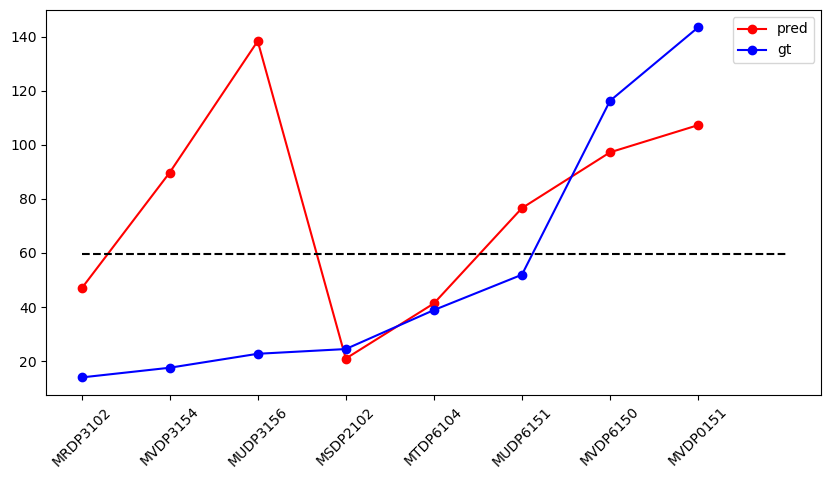

('BLUE', 'HP') 30 4


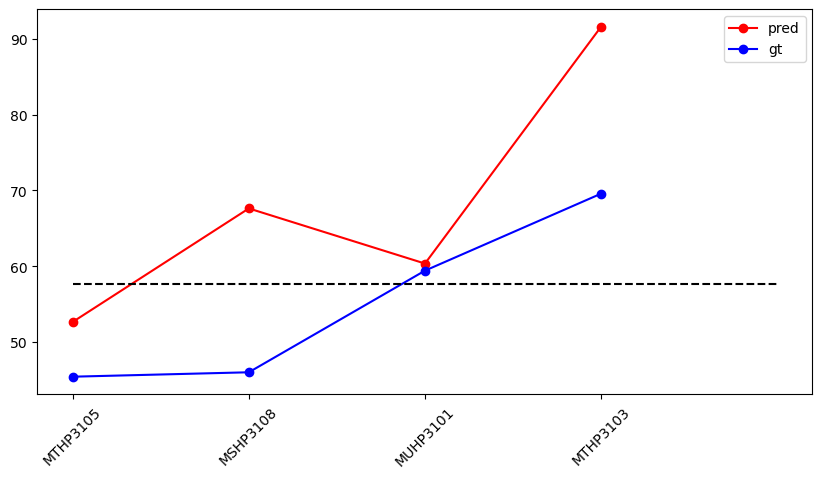

('BLUE', 'OP') 218 49


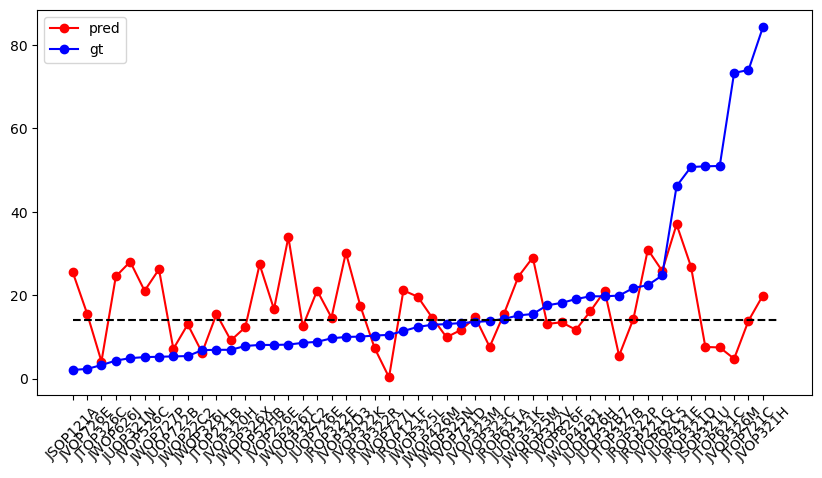

('BLUE', 'PT') 118 20


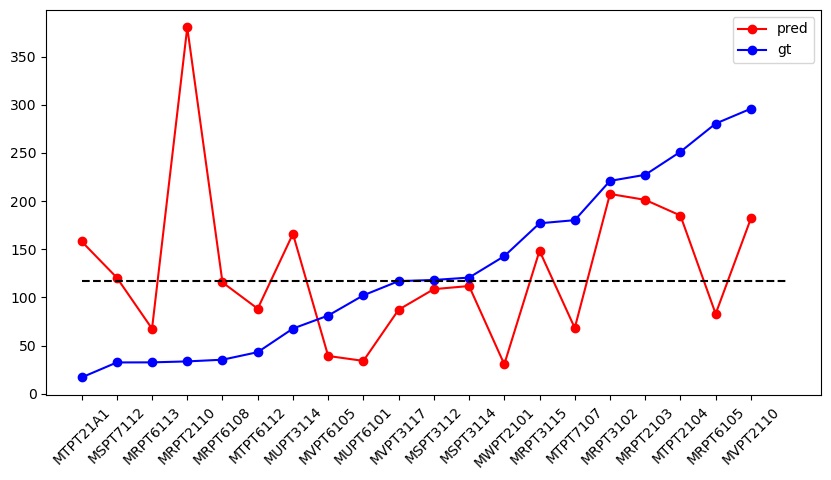

('COLOR', 'HP') 31 7


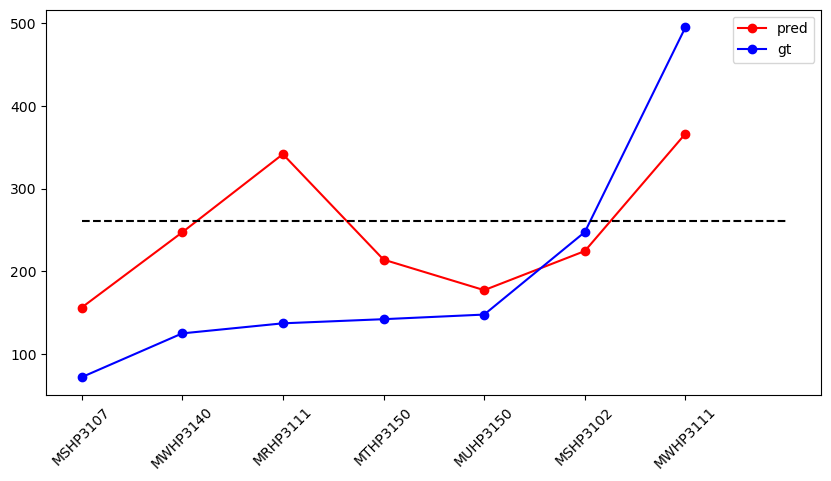

('COLOR', 'OP') 210 46


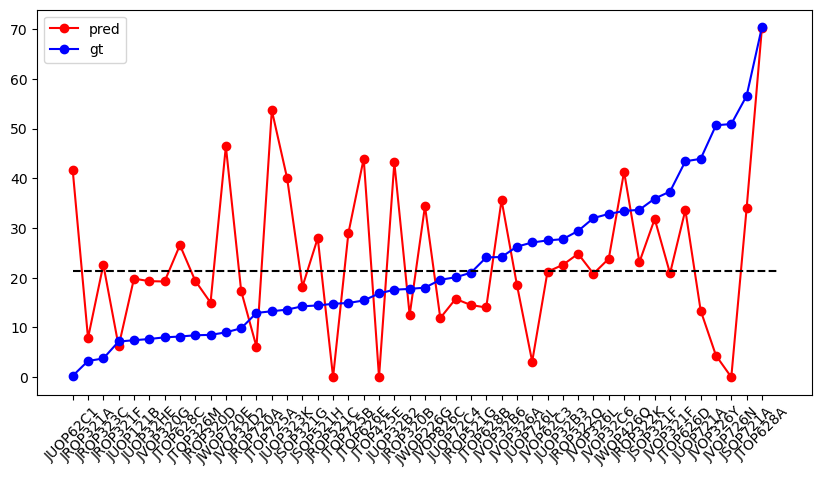

('COLOR', 'PT') 160 43


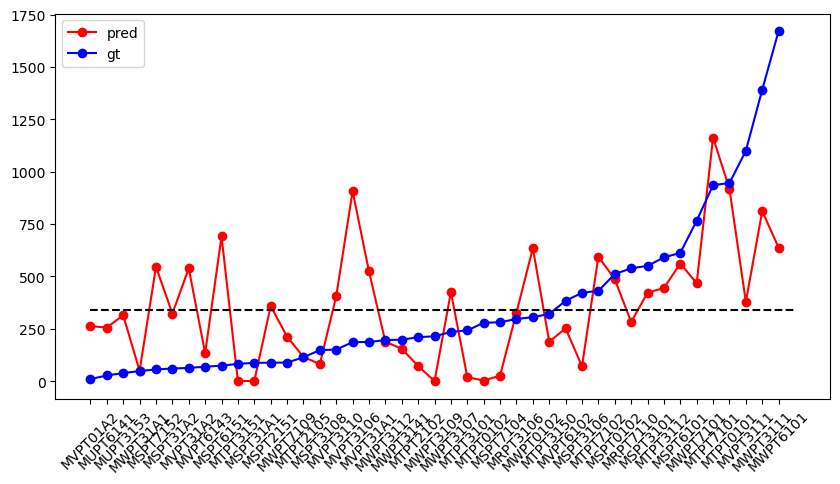

('GREEN', 'OP') 44 12


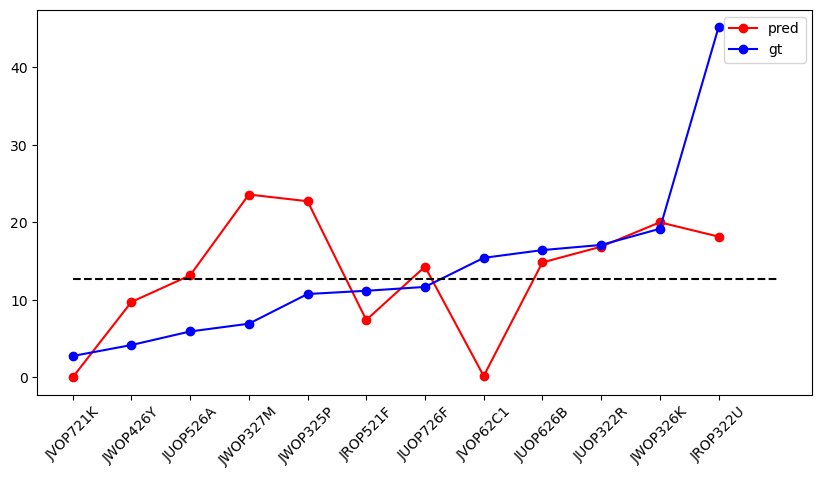

('GREY', 'PT') 95 12


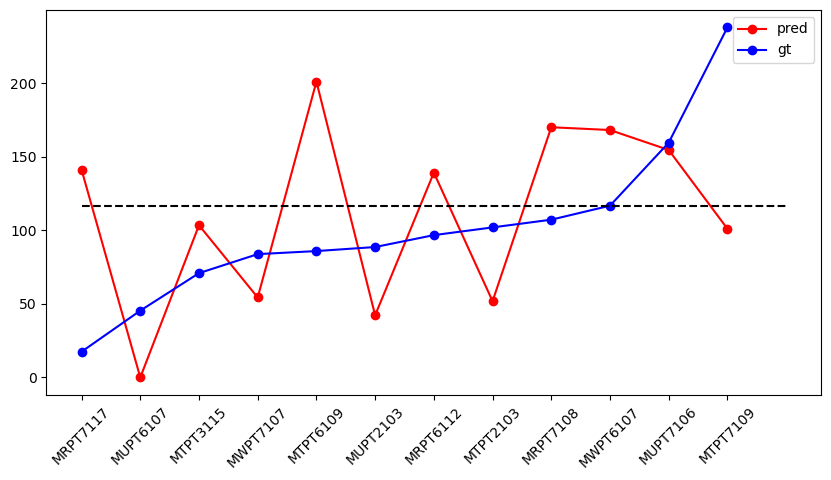

('WHITE', 'OP') 56 11


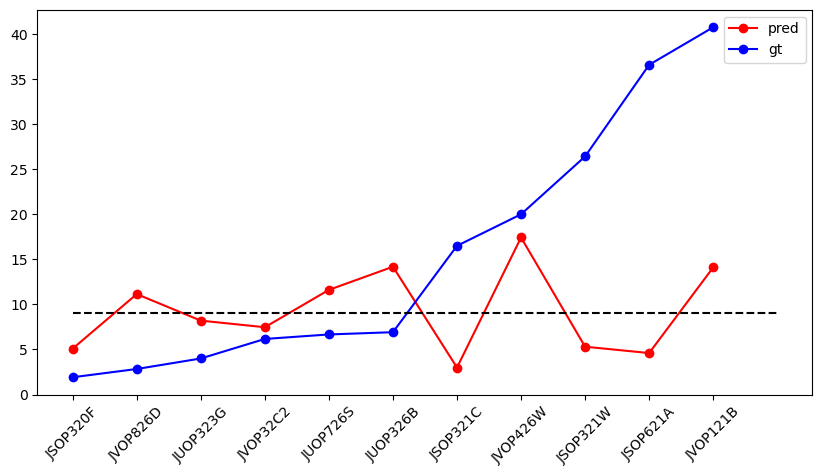

tensor(0.3701)

In [12]:
train_df_list = list(mg_train.groupby(['color', 'category'], as_index=False))
test_df_list = list(mg_test.groupby(['color', 'category'], as_index=False))

total_score = 0

for idx, (train_row, test_row) in enumerate(zip(train_df_list, test_df_list)):
    _, train_row = train_row
    cc_idx, test_row = test_row

    print(cc_idx, len(train_row), len(test_row))

    # with open(f"../../data/index/index_list{idx}", "wb") as fp:
    #     idx_list = train_row.index.append(test_row.index).tolist()
    #     pickle.dump(idx_list, fp)

    X_train = train_row.iloc[:,4:-2].values
    y_train = train_row['diff'].values

    X_test = test_row.iloc[:,4:-2].values
    y_test = test_row['sales_mean'].values

    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test) + test_row['group_mean'].values[0]
    y_pred[y_pred < 0] = 0

    score = metric(y_pred, y_test)
    total_score += score*X_test.shape[0]


    plot_idx = y_test.argsort(axis=0)

    plt.figure(figsize=(10,5))
    # plt.plot(test_row.index[plot_idx], y_pred[plot_idx], 'ro', label='pred')
    # plt.plot(test_row.index[plot_idx], y_test[plot_idx], 'bo', label='gt')
    plt.plot(test_row.index[plot_idx], y_pred[plot_idx], 'r', label='pred', marker='o')
    plt.plot(test_row.index[plot_idx], y_test[plot_idx], 'b', label='gt', marker='o')
    plt.hlines(test_row['group_mean'].values[0], 0, len(plot_idx), 'black', linestyles='--')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

total_score /= len(mg_test) 
total_score

In [16]:
colcat = df.groupby(['color', 'category'], as_index=False)['sales_mean'].agg(['count','mean'])
colcat = colcat.rename({'mean':'group_mean'}, axis=1)
colcat = colcat.loc[colcat['count'] >= 30, ['color','category','group_mean']].reset_index(drop=True)

mg_df = pd.merge(df.reset_index(), colcat).set_index('item_number')
mg_df['diff'] = mg_df['sales_mean'] - mg_df['group_mean']

In [18]:
mg_df

,fabric,color,category,sales_mean,img_0,img_1,img_2,img_3,img_4,img_5,...,text_760,text_761,text_762,text_763,text_764,text_765,text_766,text_767,group_mean,diff
item_number,,,,,,,,,,,,,,,,,,,,,
JPOP123A,WOVEN,COLOR,OP,4.833333,0.384329,0.609784,0.494033,0.440761,0.535129,0.435528,...,-1.337279,-0.380741,1.140555,-0.459688,-0.025504,-0.183534,0.030155,-0.070778,21.522086,-16.688753
JPOP123C,WOVEN,COLOR,OP,6.166667,0.382188,0.536707,0.470578,0.424661,0.558246,0.527355,...,-1.239778,-0.607263,1.099746,-0.256968,-0.146110,-0.293461,0.178971,0.033702,21.522086,-15.355420
JPOP221E,WOVEN,COLOR,OP,2.666667,0.382305,0.570584,0.445163,0.456422,0.587643,0.537279,...,-1.341965,-0.317987,0.913794,-0.476295,0.130029,-0.074771,0.266011,0.085632,21.522086,-18.855420
JPOP222A,WOVEN,COLOR,OP,1.250000,0.359036,0.546578,0.443719,0.381349,0.575302,0.540393,...,-1.464226,-0.540539,1.224415,-0.432341,-0.275168,-0.226949,-0.210263,-0.063138,21.522086,-20.272086
JPOP223C,WOVEN,COLOR,OP,3.500000,0.381857,0.537585,0.439103,0.380778,0.535126,0.489464,...,-1.239140,-0.462188,1.166340,-0.265327,-0.073699,-0.186644,0.241457,-0.027033,21.522086,-18.022086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MWPT2140,WOVEN,BLACK,PT,51.750000,0.355014,0.544174,0.539553,0.384365,0.562053,0.519871,...,-1.101200,-0.395421,1.072244,-0.521485,-0.387648,0.109319,0.290792,-0.133789,48.274123,3.475877
MWPT3113,WOVEN,BLACK,PT,162.750000,0.394823,0.516066,0.446600,0.410471,0.510012,0.527445,...,-0.893602,-0.623146,1.315621,-0.461789,-0.403074,-0.245026,0.478999,-0.044045,48.274123,114.475877
MWPT6104,WOVEN,BLACK,PT,87.583333,0.371469,0.571369,0.492617,0.419442,0.583832,0.488216,...,-0.957544,-0.429558,1.079334,-0.413682,0.016047,-0.054601,0.187982,-0.036331,48.274123,39.309211


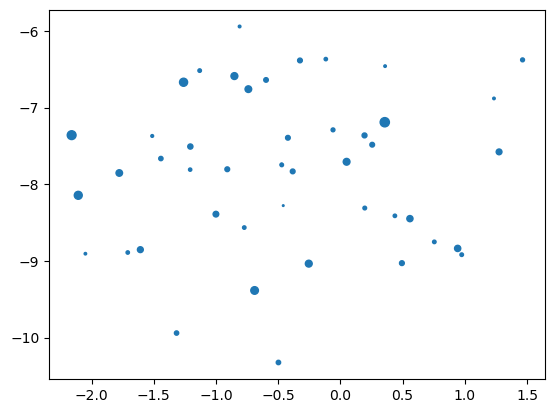

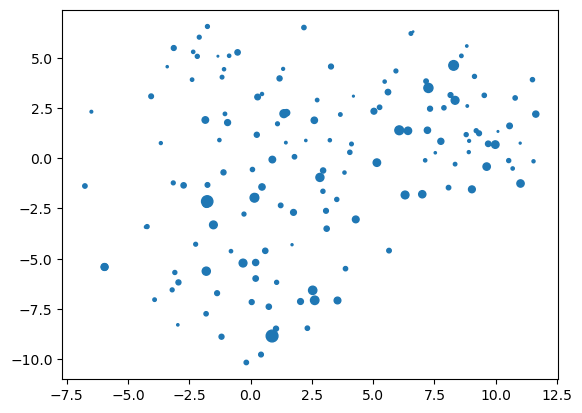

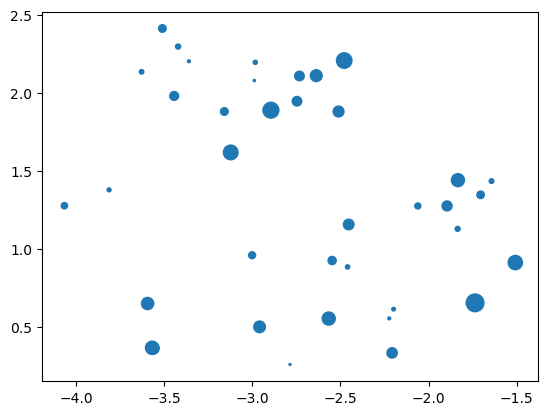

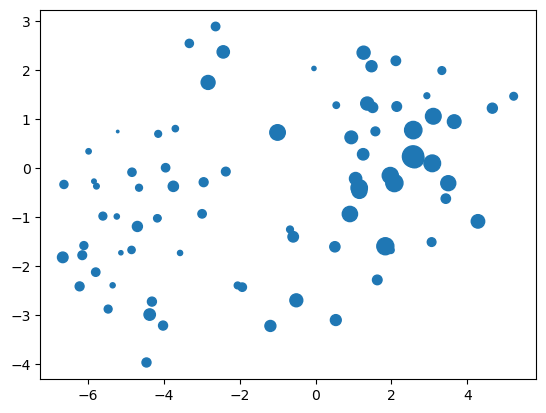

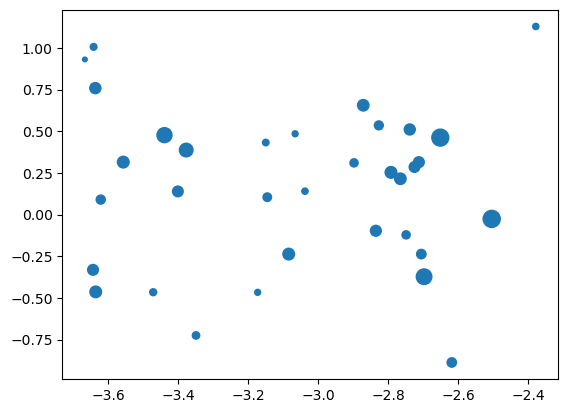

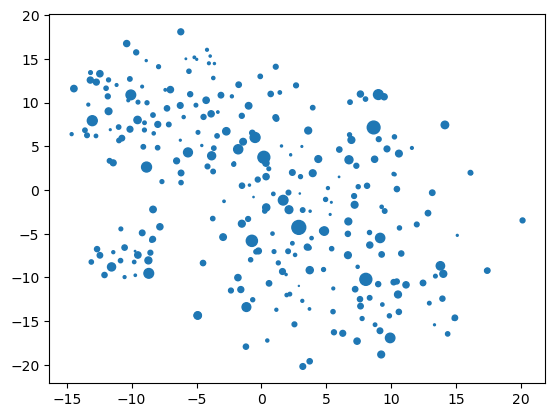

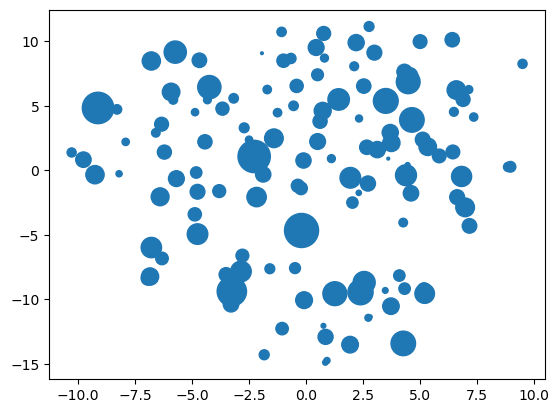

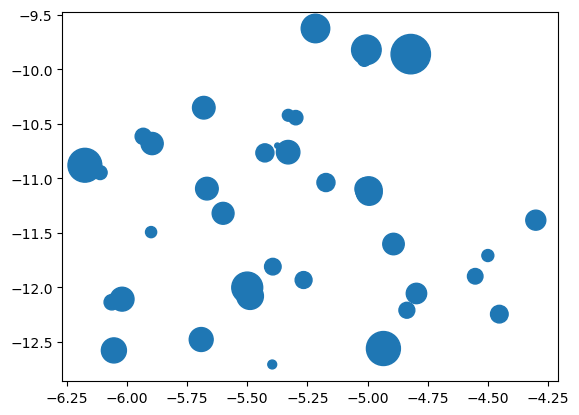

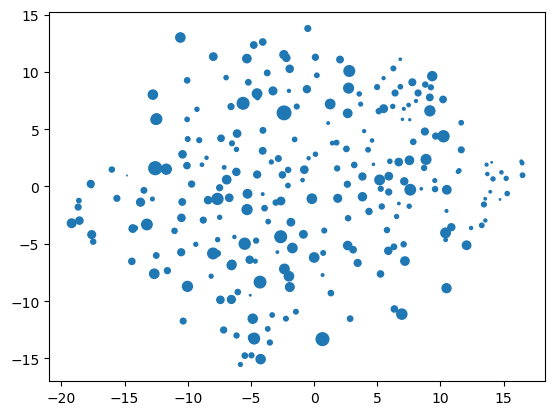

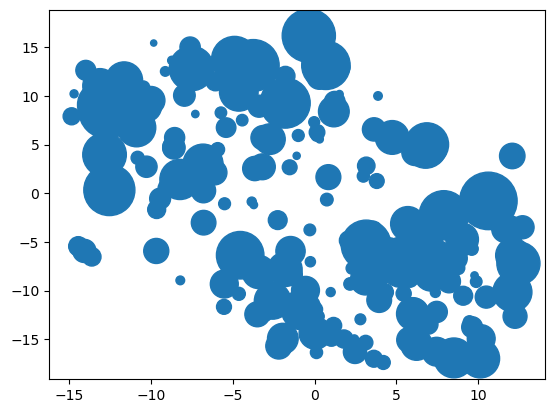

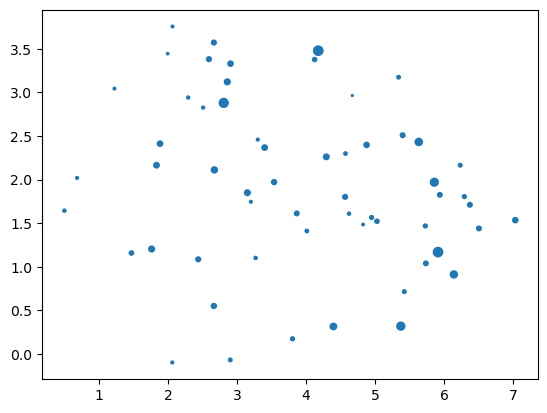

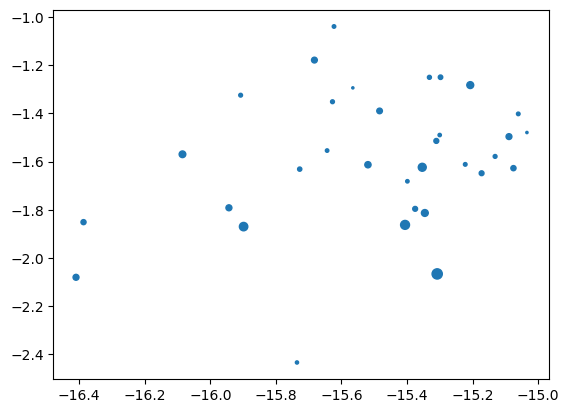

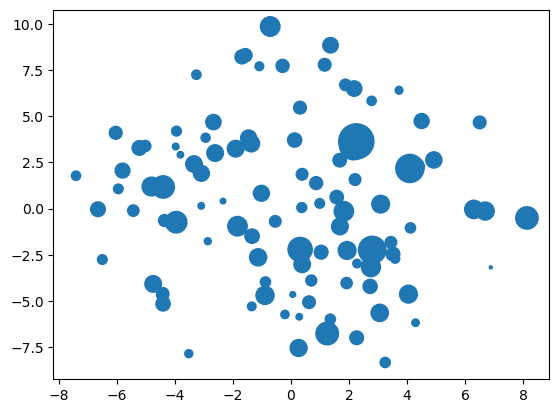

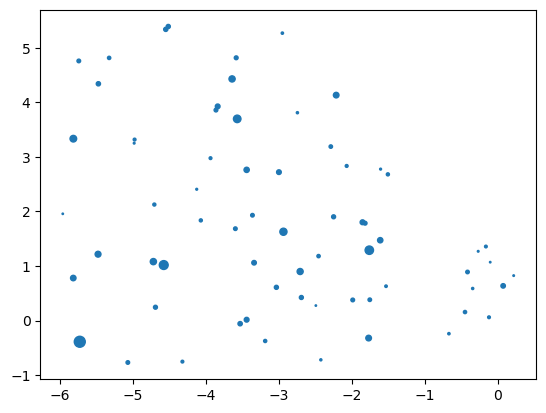

In [21]:
for idx, temp_df in list(mg_df.groupby(['color', 'category'], as_index=False)):
    tsne_emb = TSNE(n_components = 2).fit_transform(temp_df.iloc[:,4:-2])
    tsne_df = pd.DataFrame(tsne_emb, columns = ['x', 'y'])
    tsne_df['sales_mean'] = temp_df['sales_mean'].values
    plt.scatter(tsne_df['x'], tsne_df['y'], sizes=tsne_df['sales_mean'])
    plt.show()